## Imports

In [2]:
# Enable automatic extension autoreloading
%load_ext autoreload
%autoreload 2

In [3]:
!conda env list

# conda environments:
#
base                     /fsx/home-augustas/anaconda3
elk                   *  /fsx/home-augustas/anaconda3/envs/elk



In [4]:
from pathlib import Path

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch

import datasets
from datasets import load_dataset
# Don't show progress datasets bars
datasets.disable_progress_bar()

import sys
sys.path.insert(0, str(Path.cwd().parent.resolve()))
from dataset import get_dataset, collator
from model import get_model
from reward_model import get_reward_model
from utils import get_tokenizer
from trainer import get_rewards

ELK_PATH = Path("/fsx/home-augustas/elk/")
modules = [
    ELK_PATH,
    ELK_PATH / "elk" / "promptsource",
]
for module in modules:
    if not str(module) in sys.path:
        sys.path.insert(0, str(module.resolve()))

print(sys.path[:2])

from templates import DatasetTemplates

['/fsx/home-augustas/elk/elk/promptsource', '/fsx/home-augustas/elk/elk/training']


## Config

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
dataset_name = "AugustasM/burns-datasets-VINC-ppo-training-v4"
reward_model_output_path = "/fsx/home-augustas/logs/unifiedqa-v2-t5-3b-1363200_custom_data_v4_all_20230629_120158_21789"

In [7]:
# Get the reward model
reward_model, reward_model_name = get_reward_model(
    reward_model_output_path, device,
)
reward_model_tokenizer = get_tokenizer(reward_model_name)

The current device is cuda.

Loading reward model from allenai/unifiedqa-v2-t5-3b-1363200.
is_bf16_possible=True
Loaded reward model with 2,851,598,336 parameters.
Reward model dtype: torch.bfloat16

Loading reporter from /fsx/home-augustas/VINC-logs/allenai/unifiedqa-v2-t5-3b-1363200/AugustasM/burns-datasets-VINC-v4/festive-feistel/reporters/layer_19.pt
Loaded reporter.

Loading tokenizer allenai/unifiedqa-v2-t5-3b-1363200...
Falling back to slow tokenizer; fast one failed: 'No such file or directory (os error 2)'
Loaded tokenizer.



In [23]:
# Dataset for PPO training
dataset = load_dataset(dataset_name, split="train")
dataset = dataset.filter(lambda x: x["original_dataset"] != "piqa")

dataset

Found cached dataset parquet (/admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-ppo-training-v4-278eadae0cef7ee6/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-ppo-training-v4-278eadae0cef7ee6/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-bd362e59c47e1c30.arrow


Dataset({
    features: ['original_dataset', 'template_name', 'prompt', 'best_response'],
    num_rows: 8615
})

In [24]:
dataset_template_path = "AugustasM/burns-datasets-VINC/first"

dataset_templates = DatasetTemplates(dataset_template_path)
dataset_templates.templates = {
    x.name: x for x in dataset_templates.templates.values()
}
print(len(dataset_templates.templates))

template = list(dataset_templates.templates.values())[0]
template

1


In [25]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=32, collate_fn=collator,
    num_workers=12, shuffle=False,
)
print(f"Dataloader length: {len(dataloader)}")

rewards = []

for batch in tqdm(dataloader, total=len(dataloader), leave=False):
    texts = [q + r for q, r in zip(batch["prompt"], batch["best_response"])]

    current_rewards = get_rewards(texts, reward_model, reward_model_tokenizer, template, device)
    rewards.append(current_rewards.cpu())

rewards = torch.cat(rewards, dim=0)
rewards.shape

Dataloader length: 270


  0%|          | 0/270 [00:00<?, ?it/s]

torch.Size([8615])

In [26]:
mean = rewards.mean()
std = rewards.std()

mean, std

(tensor(0.4729), tensor(0.0769))

In [29]:
mean - 2 * std, mean + 2 * std

(tensor(0.3190), tensor(0.6267))

In [30]:
rewards.min(), rewards.max()

(tensor(0.1844), tensor(0.8630))

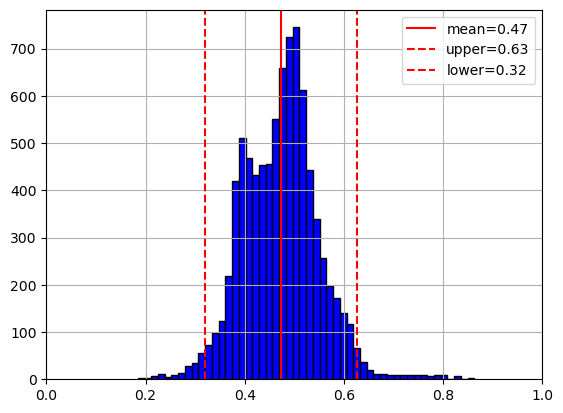

In [32]:
def plot_histogram(rewards, bins=100, color="blue", secondary_color="red", alpha=1):
    mean = rewards.mean()
    std = rewards.std()

    # Histogram of rewards with black borders
    plt.hist(rewards, bins=bins, edgecolor="black", color=color, alpha=alpha);

    # Plot vertical lines for mean +- std
    plt.axvline(mean, color=secondary_color, label=f"{mean=:.2f}")
    plt.axvline(mean + 2 * std, color=secondary_color, linestyle="--", label=f"upper={mean + 2 * std:.2f}")
    plt.axvline(mean - 2 * std, color=secondary_color, linestyle="--", label=f"lower={mean - 2 * std:.2f}");

    # Set xlim to 0-1
    plt.xlim(0, 1)

    # Legend
    plt.legend()

plot_histogram(rewards, bins=50)
plt.grid();

## Check results on the original dataset

In [20]:
seed = 42

In [33]:
dataset = load_dataset("AugustasM/burns-datasets-VINC-v4")
dataset = dataset.filter(lambda x: x["original_dataset"] != "piqa")
dataset

Found cached dataset parquet (/admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-v4-0ca8848563c71f64/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'original_dataset', 'template_name'],
        num_rows: 8800
    })
    validation: Dataset({
        features: ['text', 'label', 'original_dataset', 'template_name'],
        num_rows: 1062
    })
})

In [34]:
train_dataset = dataset["train"].shuffle(seed=seed).select(range(1000))
valid_dataset = dataset["validation"]

train_dataset, valid_dataset

(Dataset({
     features: ['text', 'label', 'original_dataset', 'template_name'],
     num_rows: 1000
 }),
 Dataset({
     features: ['text', 'label', 'original_dataset', 'template_name'],
     num_rows: 1062
 }))

In [70]:
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32, collate_fn=collator,
    num_workers=12, shuffle=False,
)
print(f"Dataloader length: {len(dataloader)}")

rewards = []
labels = []

for batch in tqdm(dataloader, total=len(dataloader), leave=False):
    texts = batch["text"]
    labels.extend(batch["label"])

    current_rewards = get_rewards(texts, reward_model, reward_model_tokenizer, template, device)
    rewards.append(current_rewards.cpu())

rewards = torch.cat(rewards, dim=0)
labels = torch.BoolTensor(labels)
rewards.shape, labels.shape

Dataloader length: 32


  0%|          | 0/32 [00:00<?, ?it/s]

(torch.Size([1000]), torch.Size([1000]))

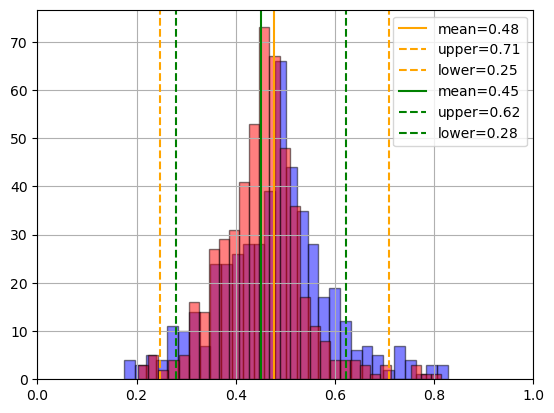

In [71]:
bins = 30
plot_histogram(rewards[labels], bins=bins, color="blue", secondary_color="orange", alpha=0.5)
plot_histogram(rewards[~labels], bins=bins, color="red", secondary_color="green", alpha=0.5)
# Grid
plt.grid()

In [ ]:
dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=32, collate_fn=collator,
    num_workers=12, shuffle=False,
)
print(f"Dataloader length: {len(dataloader)}")

rewards = []
labels = []

for batch in tqdm(dataloader, total=len(dataloader), leave=False):
    texts = batch["text"]
    labels.extend(batch["label"])

    current_rewards = get_rewards(texts, reward_model, reward_model_tokenizer, template, device)
    rewards.append(current_rewards.cpu())

rewards = torch.cat(rewards, dim=0)
labels = torch.BoolTensor(labels)
rewards.shape, labels.shape

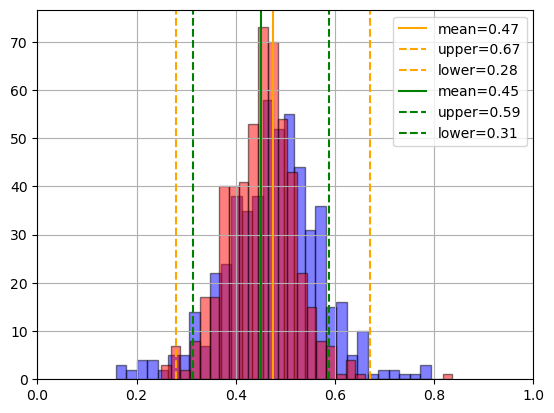

In [69]:
bins = 30
plot_histogram(rewards[labels], bins=bins, color="blue", secondary_color="orange", alpha=0.5)
plot_histogram(rewards[~labels], bins=bins, color="red", secondary_color="green", alpha=0.5)
# Grid
plt.grid()

## Check with generation

In [10]:
tokenizer = get_tokenizer("gpt2-xl")

# Dataset for PPO training
ppo_dataset, prompt_max_len, response_max_len = get_dataset(
    dataset_name, tokenizer, subsets_to_delete=["piqa"]
)
ppo_dataset

Loading tokenizer gpt2-xl...


Using pad_token, but it is not set yet.


Loaded tokenizer.

Loading dataset...



Found cached dataset parquet (/admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-ppo-training-v4-278eadae0cef7ee6/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-ppo-training-v4-278eadae0cef7ee6/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-bc44c211aecff264.arrow


Deleting subset: piqa


Loading cached processed dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-ppo-training-v4-278eadae0cef7ee6/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-e84283e14a9ce832_*_of_00012.arrow



Max prompt length: 550



Loading cached processed dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--burns-datasets-VINC-ppo-training-v4-278eadae0cef7ee6/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-3ebe5b8d17f618e6_*_of_00012.arrow


Max response length: 11

Remaining columns: ['prompt', 'input_ids', 'attention_mask', 'response_len']

Total number of examples: 8615

Processing finished.



Dataset({
    features: ['prompt', 'input_ids', 'attention_mask', 'response_len'],
    num_rows: 8615
})

In [11]:
model = get_model("gpt2-xl", device)

Loading policy model...



is_bf16_possible=True
Loaded subject model with 1,557,612,801 parameters.
Model dtype: torch.bfloat16



In [15]:
from trl import PPOTrainer, PPOConfig

config = PPOConfig()

optimizer = None

# We then build the PPOTrainer, passing the model, the reference model, the tokenizer
ppo_trainer = PPOTrainer(
    config,
    model,
    ref_model=None,
    tokenizer=tokenizer,
    dataset=ppo_dataset,
    data_collator=collator,
    optimizer=optimizer,
)

In [16]:
dataloader = torch.utils.data.DataLoader(
    ppo_dataset,
    batch_size=32, collate_fn=collator,
    num_workers=12, shuffle=False,
)
print(f"Dataloader length: {len(dataloader)}")

generation_kwargs = {
    "top_k": 0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": 100_000, # why is this value like this?
    "pad_to_multiple_of": 8, # TODO: double-check, but this seems to work and to be faster
}

rewards = []
labels = []

for batch in tqdm(dataloader, total=len(dataloader), leave=False):
    question_tensors = batch["input_ids"]

    max_new_tokens = max(batch["response_len"])
    max_new_tokens = max(4, max_new_tokens)
    generation_kwargs["max_new_tokens"] = max_new_tokens

    response_tensors = ppo_trainer.generate(
        question_tensors,
        return_prompt=False,
        # length_sampler=output_length_sampler, # TODO: can be none
        batch_size=4, # TODO: generations are made in batches
        **generation_kwargs,
    )
    batch["response"] = tokenizer.batch_decode(response_tensors, skip_special_tokens=True)

    # Compute sentiment score
    texts = [q + r for q, r in zip(batch["prompt"], batch["response"])]

    current_rewards = get_rewards(texts, reward_model, reward_model_tokenizer, template, device)
    rewards.append(current_rewards.cpu())

rewards = torch.cat(rewards, dim=0)
rewards.shape

Dataloader length: 270


  0%|          | 0/270 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors


torch.Size([8615])

In [22]:
rewards.min(), rewards.max()

(tensor(0.1979), tensor(0.8157))

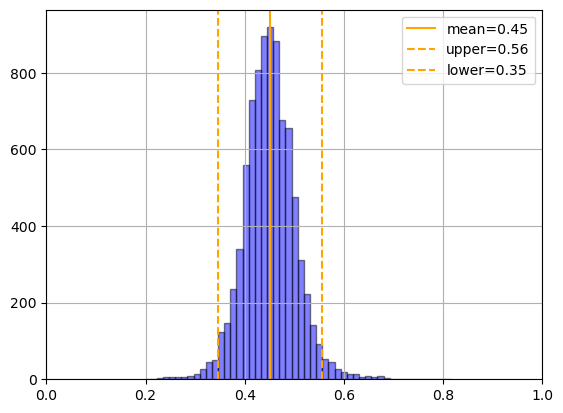

In [21]:
bins = 50
plot_histogram(rewards, bins=bins, color="blue", secondary_color="orange", alpha=0.5)
# Grid
plt.grid()